# DT8122 - Assignment

<span style="color:red">Deadline: 2023 August 15 AoE (Anywhere on Earth)</span>

Send a zip file with the notebook both as a .ipynb and as a .pdf file to <a href="mailto:dt8122@idi.ntnu.no">dt8122@idi.ntnu.no</a>. Label the file with your full name.

The task is to implement conditional DDPM for MNIST images. Your implementation should take as input a digit and be able to generate 28x28 grayscale handwritten image of said digit. 

You can add additional cells anywhere in the notebook to make your code more readable.

DDPM: https://arxiv.org/abs/2006.11239

Classifier-free conditional DDPM: https://arxiv.org/abs/2207.12598

The notebook should be run when it is turned in so all plots are visible. All code should be contained in the notebook.


### Install necessary libraries
Any additional libraries you make use of should be installed in this cell.

### Import libraries
All import statements should be contained here.

In [1]:
import random
import math

import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

from typing import Optional, Tuple, TypeVar
import numpy as np
from tqdm import tqdm

### Define constants here
Constants such as number of epochs, device, and learning rate and other hyperparameters should be defined here.

In [4]:
SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 512
##number of steps for defusion and denoising
N = 1000
BMIN = 0.0001
BMAX = 0.02
guidence_w = 0.5
device = "cuda:0"


### Functionality for loading and visualizing dataset
We have provided some functionality for loading and visualizing the dataset. You may add more cells/functions here.

In [15]:
## from 0-1 to -1-1
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [16]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

tensor([6, 1, 6, 7, 3, 5, 4, 7, 3, 7, 6, 1, 3, 3, 8, 1, 8, 5, 4, 5, 3, 4, 6, 2,
        5, 6, 9, 5, 5, 4, 8, 1, 0, 7, 1, 2, 5, 0, 5, 7, 5, 4, 4, 1, 8, 5, 6, 7,
        6, 5, 3, 0, 6, 3, 9, 2, 5, 3, 2, 2, 9, 4, 0, 3, 2, 6, 1, 0, 6, 0, 9, 7,
        3, 6, 0, 3, 3, 1, 3, 1, 6, 2, 6, 7, 5, 0, 1, 0, 6, 1, 6, 4, 5, 5, 6, 6,
        7, 6, 4, 8, 2, 6, 6, 3, 9, 3, 0, 5, 3, 3, 0, 9, 0, 9, 5, 9, 7, 2, 9, 1,
        7, 9, 8, 4, 0, 0, 0, 9, 1, 1, 0, 1, 2, 6, 5, 3, 7, 0, 1, 6, 5, 0, 3, 1,
        1, 5, 5, 3, 1, 7, 4, 0, 8, 4, 2, 9, 9, 3, 9, 5, 5, 5, 1, 9, 5, 8, 1, 1,
        3, 7, 7, 1, 0, 3, 8, 8, 4, 3, 0, 5, 6, 7, 0, 9, 8, 1, 0, 2, 1, 1, 9, 3,
        0, 5, 7, 9, 4, 7, 7, 6, 9, 2, 5, 3, 5, 1, 8, 8, 0, 5, 4, 8, 5, 1, 6, 1,
        1, 1, 4, 8, 0, 2, 1, 3, 9, 7, 6, 9, 4, 7, 6, 2, 9, 9, 6, 1, 3, 5, 4, 3,
        1, 0, 0, 7, 5, 3, 5, 0, 6, 4, 5, 2, 2, 0, 0, 1, 5, 5, 4, 4, 6, 4, 2, 3,
        7, 8, 8, 3, 6, 0, 3, 9, 1, 6, 9, 3, 2, 3, 5, 6, 6, 4, 6, 7, 3, 6, 1, 0,
        3, 9, 2, 6, 2, 3, 2, 2, 9, 4, 1,

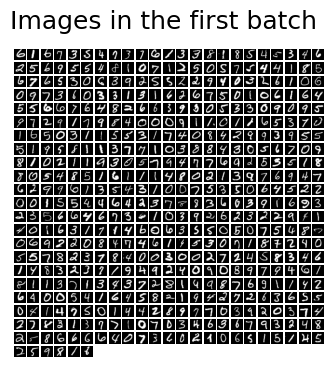

In [17]:
def show_first_batch(loader):
    for batch_feats,batch_labels in loader:
        print(batch_labels)
        print(batch_feats.shape)
        show_images(batch_feats, "Images in the first batch")
        break
show_first_batch(loader)

### Your conditional DDPM implementation should go here
This includes functionality for adding noise to the image.

In [6]:
class Forward_pass:
    def __init__(self) -> None:
        #number of steps
        self.N = N
        self.beta_min = BMIN
        self.beta_max = BMAX
        self._betas, self._alphas, self._alpha_bars = (0, 0 ,0)
        self.get_coefs()
    
    ##linear steps     
    def get_coefs(self):
        """Get the coefficients for the noise schedule.
        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]: 
                betas, alphas, alpha_bars
        """        
        self._betas = torch.linspace(self.beta_min, self.beta_max, self.N)
        self._alphas = 1 - self._betas
        self._alpha_bars = torch.cumprod(self._alphas, dim=0)

    #return the coef for initializing the denoising model
    def ret_coefs(self) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:

        return (self._betas,self._alphas,self._alpha_bars) 
   
    def _q_mean(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> torch.FloatTensor:
        # mean of the distribution q(z_t | z_0)
        sqrt_alpha_bars = torch.sqrt(self._alpha_bars[t.tolist()])
        return sqrt_alpha_bars.view(-1,1,1,1) * z

    def _q_std(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> torch.FloatTensor:
        # std of the distribution q(z_t | z_0)
        std = torch.sqrt(1.0 - self._alpha_bars[t.tolist()])
        return std.view(-1,1,1,1)

    def q_sample(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        # Sample from q(z_t | z_0)

        mean = self._q_mean(z, t)
        std = self._q_std(z, t)
        epsilon = torch.randn_like(z)
        z_t = epsilon * std + mean

        return z_t, epsilon
    
    ##for training, sample random n timesteps for each input, return the repeated features, times-steps sampled and the episilons
    def q_sample_random(
        self,
        z: torch.FloatTensor,
        lables: torch.FloatTensor,
        n_timesteps = 5,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,  torch.FloatTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = list(torch.randint(0, self.N-1, (n_timesteps,)))
        print(times)
        times_list = [torch.Tensor([i]).repeat(z.shape[0]).to(torch.int64) for i in times ]
        times_repeated = torch.cat(times_list)
        lables_repeated = lables.repeat(n_timesteps)
        z_repeated = z.repeat(n_timesteps,1,1,1) #shape=(batch_size*5, 1, 28, 28)
        mean = self._q_mean(z_repeated, times_repeated)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z_repeated, times_repeated)
        epsilon = torch.randn_like(z_repeated)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times_repeated, lables_repeated
    
    
    ##for training, sample randomly one timestep for each img, return the repeated features, times-steps sampled and the episilons
    def q_sample_random2(
        self,
        z: torch.FloatTensor,
        lables: torch.FloatTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,   torch.IntTensor, torch.IntTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = torch.randint(0, self.N-1, (z.shape[0],))
        mean = self._q_mean(z, times)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z, times)
        epsilon = torch.randn_like(z)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times, lables
    
    def q_sample_random_unconditional(
        self,
        z: torch.FloatTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,  torch.IntTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = torch.randint(0, self.N-1, (z.shape[0],))
        mean = self._q_mean(z, times)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z, times)
        epsilon = torch.randn_like(z)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times

### The implementation of the neural network used to estimate the noise should go here
The network should make use of both time and context embedding.

Any functions/methods used for time and context embeddings should also go here.

In [7]:
## we use only simple residual-CNN as the backbone models (copied from https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py)
class ResidualConvBlock(torch.nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.GELU(),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class ConditionedBackbone(torch.nn.Module):
    def __init__(self, in_channels = 1, hidden_channels = 256, image_size = 28, n_classes=11, n_layers=8, num_timesteps=N) -> None:
        super(ConditionedBackbone, self).__init__()

        self.in_channels = in_channels
        self.n_feat = hidden_channels
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.image_size = image_size
        self.num_timesteps = num_timesteps

        self.conv_layers = torch.nn.Sequential()
        self.conv_layers.add_module("conv_init", ResidualConvBlock(self.in_channels, hidden_channels, is_res=True))
        for i in range(n_layers-2):
            self.conv_layers.add_module(f'conv{i}',ResidualConvBlock(hidden_channels, hidden_channels, is_res=True))
        self.conv_layers.add_module("conv_final", ResidualConvBlock(hidden_channels, self.in_channels, is_res=True))

        #for simplicity we only add trainable embeddings to the input feature map(Xt), the size is the image size
        self.time_emb = torch.nn.Linear(self.num_timesteps, self.image_size**2) 
        self.lable_emb = torch.nn.Linear(n_classes, self.image_size**2)
        
    def forward(self, x, lables, t) -> float:
        # x is (noisy) image batch (from the Forward_pass for training and from the N(0,1) for sampling),  (batch_size, channel(1), 28, 28)
        # diff_noise are the corresponding noise in the forward pass, 
        #labels are the numbers from 0-10, 10 represents the unconditioned sample, t is the timestep usually from 0-999, 

        # using one hot embedding for the lable and time and a learned transformation
        lables = torch.nn.functional.one_hot(lables, num_classes=self.n_classes).type(torch.float)
        time_steps = torch.nn.functional.one_hot(t, num_classes=N).type(torch.float)
        #prepare the conditioned input 
        lable_embedding  = self.lable_emb(lables).view(-1, 1, self.image_size, self.image_size)
        time_embdding = self.time_emb(time_steps).view(-1, 1, self.image_size, self.image_size) 
        
        #feed into the network and predict the noise
        e_pred = self.conv_layers(x + lable_embedding + time_embdding)
        
        return e_pred
    
class UnconditionedBackbone(torch.nn.Module):
    def __init__(self, in_channels = 1, hidden_channels = 256, image_size = 28,  n_layers=8, num_timesteps=N) -> None:
        super(UnconditionedBackbone, self).__init__()

        self.in_channels = in_channels
        self.n_feat = hidden_channels
        self.n_layers = n_layers
        self.image_size = image_size
        self.num_timesteps = num_timesteps

        self.conv_layers = torch.nn.Sequential()
        self.conv_layers.add_module("conv_init", ResidualConvBlock(self.in_channels, hidden_channels, is_res=True))
        for i in range(n_layers-2):
            self.conv_layers.add_module(f'conv{i}',ResidualConvBlock(hidden_channels, hidden_channels, is_res=True))
        self.conv_layers.add_module("conv_final", ResidualConvBlock(hidden_channels, self.in_channels, is_res=True))

        #for simplicity we only add trainable embeddings to the input feature map(Xt), the size is the image size
        self.time_emb = torch.nn.Linear(self.num_timesteps, self.image_size**2) 
        
    def forward(self, x, t) -> float:
        # x is (noisy) image batch (from the Forward_pass for training and from the N(0,1) for sampling),  (batch_size, channel(1), 28, 28)
        # diff_noise are the corresponding noise in the forward pass, 
        #labels are the numbers from 0-10, 10 represents the unconditioned sample, t is the timestep usually from 0-999, 

        # using one hot embedding for time and a learned transformation
        time_steps = torch.nn.functional.one_hot(t, num_classes=N).type(torch.float)
        time_embdding = self.time_emb(time_steps).view(-1, 1, self.image_size, self.image_size) 
        
        #feed into the network and predict the noise
        e_pred = self.conv_layers(x + time_embdding)
        
        return e_pred
    
class Reverse_pass(torch.nn.Module):
    def __init__(self, model, alphas, alpha_bars, betas, num_classes = 11 ) -> None:
        super().__init__()
        self.model = model
        #self.model.to(device)
        self.N = N
        self.num_classes = num_classes
        ##for computing the samples
        self.alphas = alphas
        self.sqrt_1_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        ##we use the simpler version of sigma for the reverse pass
        self.sigmas = torch.sqrt(betas) 
        self.guidence_w = guidence_w
        
        #loss
        self.mse = torch.nn.MSELoss()
        
    def sample(self, n_samples = 3, image_size = 28): 
        ## sample "n" samples for each number “0-9” (including the unditional label "10") using 'Classifier-Free Diffusion Guidance'
        with torch.no_grad():
            #sample noised images and arrange labels
            batch_size = n_samples*self.num_classes
            #x_batch = torch.randn(batch_size, 1, image_size, image_size).to(device)
            x_batch = torch.randn(batch_size, 1, image_size, image_size)
            ##labels = [0,0,0,1,1,1,2,2,2....]  
            labels = [ torch.tensor([i]).repeat(n_samples) for i in range(self.num_classes)]
            #labels = torch.cat(labels).to(device)
            labels = torch.cat(labels)
            # unconditioned labels for interpolation (label = 10)
            labels_uncon = torch.full_like(labels, self.num_classes-1)
            labels = torch.cat((labels, labels_uncon))
            last_batch = x_batch
            for i in range(self.N, 0, -1):
                print(f'sampling timestep {i}\n')
                #current_t = torch.tensor([i]).to(device)
                current_t = torch.tensor([i-1])  #i-1 for one-hot encoding
                t_batch = current_t.repeat(batch_size) #(batch_size)

                # duplicate the current img for unconditioned sampling
                x_doubled = last_batch.repeat(2,1,1,1) #(2*batch_size, channel, img_size, img_size)
                t_doubled = t_batch.repeat(2) #(2*batch_size)

                # predict the diffusion noise, and interpolate
                diff_noise = self.model(x_doubled, labels, t_doubled)
                diff_con = diff_noise[:batch_size]
                diff_uncon = diff_noise[batch_size:]
                diff_noise_final = (1+self.guidence_w)*diff_con - self.guidence_w*diff_uncon
                # predict x_t-1
                #observation_noise = torch.randn(batch_size, 1, image_size, image_size).to(device) if i > 1 else 0
                observation_noise = torch.randn(batch_size, 1, image_size, image_size) if i > 1 else 0
                x_predict = (1/torch.sqrt(self.alphas[i-1])) * (last_batch - diff_noise_final * (1 - self.alphas[i-1]) / self.sqrt_1_minus_alpha_bars[i-1]) + self.sigmas[i-1] * observation_noise
                
                last_batch = x_predict
            return last_batch
    
    def compute_loss(self, batch_input, batch_noise, batch_time, batch_lables):
        #a batch of diffused input (by the forward process), with its difuusion noise,  timesteps and labels as input
        # return the loss of this batch for training the model
        
        predicted_noise = self.model(batch_input, batch_lables, batch_time)
        return self.mse(batch_noise, predicted_noise)
    
    
    
class Reverse_pass_unconditional(torch.nn.Module):
    def __init__(self, model, alphas, alpha_bars, betas) -> None:
        super().__init__()
        self.model = model
        self.model.to(device)
        self.N = N
        ##for computing the samples
        self.alphas = alphas
        self.sqrt_1_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        ##we use the simpler version of sigma for the reverse pass
        self.sigmas = torch.sqrt(betas)      
        #loss
        self.mse = torch.nn.MSELoss()
        
    def sample(self, n_samples = 10, image_size = 28): 
        ## sample "n" samples for each number “0-9” (including the unditional label "10") using 'Classifier-Free Diffusion Guidance'
        with torch.no_grad():
            #sample noised images and arrange labels
            batch_size = n_samples
            x_batch = torch.randn(batch_size, 1, image_size, image_size).to(device)
            for i in range(self.N, 0, -1):
                print(f'sampling timestep {i}\n')
                current_t = torch.tensor([i-1])  #i-1 for one-hot encoding
                t_batch = current_t.repeat(batch_size).to(device) #(batch_size)

                # predict the diffusion noise, and interpolate
                diff_noise = self.model(x_batch,  t_batch)
                diff_noise_final = diff_noise
                # predict x_t-1
                #observation_noise = torch.randn(batch_size, 1, image_size, image_size).to(device) if i > 1 else 0
                observation_noise = torch.randn(batch_size, 1, image_size, image_size, device=device) if i > 1 else 0
                x_batch = (1/torch.sqrt(self.alphas[i-1])) * (x_batch - diff_noise_final * (1 - self.alphas[i-1]) / self.sqrt_1_minus_alpha_bars[i-1]) + self.sigmas[i-1] * observation_noise           
    
            return x_batch
    
    def compute_loss(self, batch_input, batch_noise, batch_time):
        #a batch of diffused input (by the forward process), with its difuusion noise,  timesteps and labels as input
        # return the loss of this batch for training the model
        
        predicted_noise = self.model(batch_input.to(device), batch_time.to(device))
        return self.mse(batch_noise.to(device), predicted_noise)

### Show that you can generate images before the model is trained
This should demonstrate that the backwards pass works. The generated images are expected to be noise.

In [1]:
model = UnconditionedBackbone()
forward = Forward_pass()
betas,alphas,alpha_bars = forward.ret_coefs()
reverse = Reverse_pass_unconditional(model, alphas, alpha_bars, betas)
return_batch = reverse.sample()
show_images(return_batch, "Images generated from the untrained model")


NameError: name 'UnconditionedBackbone' is not defined

In [9]:
model.conv_layers.conv_init.conv1[0].weight

Parameter containing:
tensor([[[[ 0.1718, -0.1471, -0.0646],
          [ 0.1565, -0.3138,  0.1999],
          [-0.0686,  0.1696,  0.0463]]],


        [[[-0.0408,  0.0925,  0.0164],
          [ 0.1217, -0.1299, -0.0243],
          [-0.0300,  0.0483, -0.0013]]],


        [[[ 0.2914,  0.1037, -0.1241],
          [-0.2013, -0.0559, -0.1438],
          [-0.1068,  0.0160,  0.1987]]],


        ...,


        [[[ 0.3323, -0.0534, -0.2994],
          [-0.0029,  0.0169, -0.1238],
          [-0.0362, -0.2718,  0.1026]]],


        [[[-0.2313,  0.1147,  0.2512],
          [-0.2152, -0.1305,  0.0321],
          [ 0.0008,  0.1954, -0.0200]]],


        [[[ 0.0539, -0.0921,  0.1099],
          [ 0.1007, -0.2684,  0.1770],
          [-0.0683,  0.2985, -0.3308]]]], device='cuda:0', requires_grad=True)

### Implement training loop
Train the model here. There should be some indication of how long the model took to train, both total and per epoch. For good results you will want to train the model for several epochs, but with a good implementation you should expect to see something that looks like digits after only a single epoch.

In [18]:
def train_conditionedDDPM(n_epochs = 10, learning_rate = 0.0001):
    print(f"{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters to train")
    optimizer = torch.optim.Adam(reverse.parameters(), lr=learning_rate)
    for i in range(n_epochs):
        print(f"Training epoch: {i+1}")
        progress_loader = tqdm(loader)
        for batch_feats,batch_labels in progress_loader:
            optimizer.zero_grad()
            #sample with forward pass
            #z_out, epsilon_target, times, labels= forward.q_sample_random(batch_feats, batch_labels)
            z_out, epsilon_target, times, labels= forward.q_sample_random2(batch_feats, batch_labels)
            loss = reverse.compute_loss(z_out, epsilon_target, times, labels)
            loss.backward()
            optimizer.step()
            
def train_unconditionedDDPM(n_epochs = 30, learning_rate = 0.0001):
    print(f"{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters to train")
    optimizer = torch.optim.Adam(reverse.parameters(), lr=learning_rate)
    for i in range(n_epochs):
        print(f"Training epoch: {i+1}")
        progress_loader = tqdm(loader)
        total_loss = 0 
        for batch_feats,batch_labels in progress_loader:
            optimizer.zero_grad()
            #sample with forward pass
            #z_out, epsilon_target, times, labels= forward.q_sample_random(batch_feats, batch_labels)
            z_out, epsilon_target, times = forward.q_sample_random_unconditional(batch_feats)
            loss = reverse.compute_loss(z_out, epsilon_target, times)
            total_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Loss for the current epoch is {total_loss}')
            

### Train and visualize the model
We want to see several generated examples of each digit.

In [19]:
model = UnconditionedBackbone()
forward = Forward_pass()
betas,alphas,alpha_bars = forward.ret_coefs()
reverse = Reverse_pass_unconditional(model, alphas, alpha_bars, betas)
train_unconditionedDDPM()

8467871 parameters to train
Training epoch: 1


100%|██████████| 118/118 [01:29<00:00,  1.32it/s]


Loss for the current epoch is 74.65718841552734
Training epoch: 2


100%|██████████| 118/118 [01:40<00:00,  1.17it/s]


Loss for the current epoch is 65.23109436035156
Training epoch: 3


100%|██████████| 118/118 [01:43<00:00,  1.13it/s]


Loss for the current epoch is 62.20560836791992
Training epoch: 4


100%|██████████| 118/118 [01:40<00:00,  1.18it/s]


Loss for the current epoch is 60.138275146484375
Training epoch: 5


100%|██████████| 118/118 [01:38<00:00,  1.20it/s]


Loss for the current epoch is 58.31080627441406
Training epoch: 6


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 56.67414855957031
Training epoch: 7


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 55.14756393432617
Training epoch: 8


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 53.66683578491211
Training epoch: 9


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 52.23731994628906
Training epoch: 10


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 50.84294891357422
Training epoch: 11


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 49.53572082519531
Training epoch: 12


100%|██████████| 118/118 [01:37<00:00,  1.22it/s]


Loss for the current epoch is 48.331138610839844
Training epoch: 13


100%|██████████| 118/118 [01:36<00:00,  1.22it/s]


Loss for the current epoch is 47.26008605957031
Training epoch: 14


100%|██████████| 118/118 [01:36<00:00,  1.22it/s]


Loss for the current epoch is 46.283050537109375
Training epoch: 15


100%|██████████| 118/118 [01:38<00:00,  1.20it/s]


Loss for the current epoch is 45.43960189819336
Training epoch: 16


100%|██████████| 118/118 [01:38<00:00,  1.20it/s]


Loss for the current epoch is 44.650390625
Training epoch: 17


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 43.97621154785156
Training epoch: 18


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 43.33008575439453
Training epoch: 19


100%|██████████| 118/118 [01:36<00:00,  1.22it/s]


Loss for the current epoch is 42.91655349731445
Training epoch: 20


100%|██████████| 118/118 [01:35<00:00,  1.24it/s]


Loss for the current epoch is 42.7554817199707
Training epoch: 21


100%|██████████| 118/118 [01:36<00:00,  1.23it/s]


Loss for the current epoch is 42.39558410644531
Training epoch: 22


100%|██████████| 118/118 [01:37<00:00,  1.22it/s]


Loss for the current epoch is 42.21128463745117
Training epoch: 23


100%|██████████| 118/118 [01:38<00:00,  1.20it/s]


Loss for the current epoch is 42.23884201049805
Training epoch: 24


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 42.01506805419922
Training epoch: 25


100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Loss for the current epoch is 41.97013854980469
Training epoch: 26


100%|██████████| 118/118 [01:36<00:00,  1.22it/s]


Loss for the current epoch is 41.91836929321289
Training epoch: 27


100%|██████████| 118/118 [01:35<00:00,  1.23it/s]


Loss for the current epoch is 41.84497833251953
Training epoch: 28


100%|██████████| 118/118 [01:35<00:00,  1.23it/s]


Loss for the current epoch is 41.885292053222656
Training epoch: 29


100%|██████████| 118/118 [01:35<00:00,  1.24it/s]


Loss for the current epoch is 41.79961013793945
Training epoch: 30


100%|██████████| 118/118 [01:34<00:00,  1.24it/s]

Loss for the current epoch is 41.76651382446289


sampling timestep 1000

sampling timestep 999

sampling timestep 998

sampling timestep 997

sampling timestep 996

sampling timestep 995

sampling timestep 994

sampling timestep 993

sampling timestep 992

sampling timestep 991

sampling timestep 990

sampling timestep 989

sampling timestep 988

sampling timestep 987

sampling timestep 986

sampling timestep 985

sampling timestep 984

sampling timestep 983

sampling timestep 982

sampling timestep 981

sampling timestep 980

sampling timestep 979

sampling timestep 978

sampling timestep 977

sampling timestep 976

sampling timestep 975

sampling timestep 974

sampling timestep 973

sampling timestep 972

sampling timestep 971

sampling timestep 970

sampling timestep 969

sampling timestep 968

sampling timestep 967

sampling timestep 966

sampling timestep 965

sampling timestep 964

sampling timestep 963

sampling timestep 962

sampling timestep 961

sampling timestep 960

sampling timestep 959

sampling timestep 958

sampling t

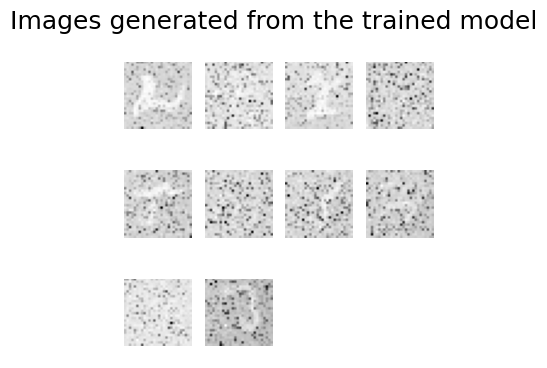

In [20]:
return_batch = reverse.sample()
show_images(return_batch, "Images generated from the trained model")